In [1]:
import pandas as pd
import re
import math
import numpy as np
import scipy
import os
import time
import seaborn as sns
from scipy.stats import binom, hypergeom
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
%matplotlib inline

In [2]:
df = pd.read_csv('data/cab_rides.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
distance            693071 non-null float64
cab_type            693071 non-null object
time_stamp          693071 non-null int64
destination         693071 non-null object
source              693071 non-null object
price               637976 non-null float64
surge_multiplier    693071 non-null float64
id                  693071 non-null object
product_id          693071 non-null object
name                693071 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [4]:
df.describe()

,distance,time_stamp,price,surge_multiplier
count,693071.000000,6.930710e+05,637976.000000,693071.000000
mean,2.189430,1.544046e+12,16.545125,1.013870
std,1.138937,6.891925e+08,9.324359,0.091641
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.280000,1.543444e+12,9.000000,1.000000
50%,2.160000,1.543737e+12,13.500000,1.000000
75%,2.920000,1.544828e+12,22.500000,1.000000
max,7.860000,1.545161e+12,97.500000,3.000000


In [5]:
df['day']=df.time_stamp.apply(lambda x: time.strftime('%a', time.localtime(x/1000)))
df['AMPM']=df.time_stamp.apply(lambda x: time.strftime('%p', time.localtime(x/1000)))
df['month']=df.time_stamp.apply(lambda x: time.strftime('%b', time.localtime(x/1000)))
df['time']=df.time_stamp.apply(lambda x: time.strftime('%H', time.localtime(x/1000)))
df['week']=df.time_stamp.apply(lambda x: time.strftime('%U', time.localtime(x/1000)))
df['date_time']=df.time_stamp.apply(lambda x: time.strftime('%Y-%m-%d %H', time.localtime(x/1000)))


In [6]:
df.week.max()

'50'

In [7]:
df.week.min()

'47'

In [8]:
df['merge_date'] = df.source.astype(str) +" - "+ df.date_time.astype("str") 



In [9]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,day,AMPM,month,time,week,date_time,merge_date
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,Sun,AM,Dec,04,50,2018-12-16 04,Haymarket Square - 2018-12-16 04
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,Mon,PM,Nov,21,47,2018-11-26 21,Haymarket Square - 2018-11-26 21
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,Tue,PM,Nov,20,47,2018-11-27 20,Haymarket Square - 2018-11-27 20
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,Thu,PM,Nov,23,47,2018-11-29 23,Haymarket Square - 2018-11-29 23
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,Wed,PM,Nov,22,47,2018-11-28 22,Haymarket Square - 2018-11-28 22


In [10]:
df1 = pd.read_csv('data/weather.csv')

In [11]:
df1.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [12]:
df1['date_time']=df1.time_stamp.apply(lambda x: time.strftime('%Y-%m-%d %H', time.localtime(x)))


In [13]:
#merge the datasets to refelect same time for a location
df1['merge_date'] = df1.location.astype(str) +" - "+ df1.date_time.astype("str") 


In [14]:
merged_df = df.merge(df1, how='inner', left_on = ['merge_date'], right_on=['merge_date'], suffixes=('_c','_w'))
merged_df.head()

,distance,cab_type,time_stamp_c,destination,source,price,surge_multiplier,id,product_id,name,...,merge_date,temp,location,clouds,pressure,rain,time_stamp_w,humidity,wind,date_time_w
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
1,1.33,Lyft,1544952309308,Beacon Hill,Haymarket Square,7.0,1.0,0d468502-34b5-447f-be9f-acbb62176072,lyft,Lyft,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
2,0.53,Lyft,1544951109578,North Station,Haymarket Square,27.5,1.0,2aa8d17e-4b13-4200-87db-db3eed73ca6b,lyft_luxsuv,Lux Black XL,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
3,2.36,Lyft,1544954108860,Back Bay,Haymarket Square,7.0,1.0,4944c164-0463-47b9-96e1-15ffe8b9c7c9,lyft_line,Shared,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
4,0.62,Uber,1544954108161,West End,Haymarket Square,10.5,1.0,b1c23003-39fb-4030-9961-4f3420b23907,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04


In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1265675 entries, 0 to 1265674
Data columns (total 26 columns):
distance            1265675 non-null float64
cab_type            1265675 non-null object
time_stamp_c        1265675 non-null int64
destination         1265675 non-null object
source              1265675 non-null object
price               1164996 non-null float64
surge_multiplier    1265675 non-null float64
id                  1265675 non-null object
product_id          1265675 non-null object
name                1265675 non-null object
day                 1265675 non-null object
AMPM                1265675 non-null object
month               1265675 non-null object
time                1265675 non-null object
week                1265675 non-null object
date_time_c         1265675 non-null object
merge_date          1265675 non-null object
temp                1265675 non-null float64
location            1265675 non-null object
clouds              1265675 non-null float64
pre

In [16]:
merged_df.drop_duplicates(subset='id', keep='first', inplace=True)

In [17]:
merged_df['time'] = merged_df['time'].astype(int)


In [18]:
merged_df['rushhr'] = 0

In [19]:
merged_df.loc[(merged_df.time > 7) & (merged_df.time < 10), 'rushhr'] = 1

In [20]:
merged_df.loc[(merged_df.time > 17) & (merged_df.time < 22), 'rushhr'] = 1

In [21]:
merged_df.groupby('time')['rushhr'].sum()

time
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8     30384
9     30384
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18    31931
19    32413
20    27768
21    28548
22        0
23        0
Name: rushhr, dtype: int64

In [22]:
merged_df = pd.get_dummies(merged_df, columns=[
                           'cab_type', 'destination', 'source', 'name', 'day', 'AMPM', 'month', 'week'])

In [23]:
merged_df.head(100)

,distance,time_stamp_c,price,surge_multiplier,id,product_id,time,date_time_c,merge_date,temp,...,day_Tue,day_Wed,AMPM_AM,AMPM_PM,month_Dec,month_Nov,week_47,week_48,week_49,week_50
0,0.44,1544952607890,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,4,2018-12-16 04,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
1,1.33,1544952309308,7.0,1.0,0d468502-34b5-447f-be9f-acbb62176072,lyft,4,2018-12-16 04,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
2,0.53,1544951109578,27.5,1.0,2aa8d17e-4b13-4200-87db-db3eed73ca6b,lyft_luxsuv,4,2018-12-16 04,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
3,2.36,1544954108860,7.0,1.0,4944c164-0463-47b9-96e1-15ffe8b9c7c9,lyft_line,4,2018-12-16 04,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
4,0.62,1544954108161,10.5,1.0,b1c23003-39fb-4030-9961-4f3420b23907,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,4,2018-12-16 04,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
5,0.49,1544953210139,26.0,1.0,b2c44c57-4728-441e-83ce-f796a55e6b20,6d318bcc-22a3-4af6-bddd-b409bfce1546,4,2018-12-16 04,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
6,0.91,1544952010722,NaN,1.0,bf959122-861a-479d-804b-fdfdc83c2011,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,4,2018-12-16 04,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
7,2.38,1544950807092,16.5,1.0,e20be752-be44-4093-8600-c48608b7079e,lyft_premier,4,2018-12-16 04,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
8,0.61,1544953511805,6.5,1.0,04f35170-0dad-4ae2-b5c9-02310e811fd8,997acbb5-e102-41e1-b155-9df7de0a73f2,4,2018-12-16 04,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
9,1.16,1544953810508,13.0,1.0,c797e710-b45d-4005-9ba6-c425ff306c05,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,4,2018-12-16 04,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1


In [24]:
merged_df['Black'] = 0

In [25]:
merged_df['Black'] = merged_df['name_Black'] + merged_df['name_Black SUV'] + \
    merged_df['name_Lux Black'] + merged_df['name_Lux Black XL']

In [26]:
merged_df.groupby('Black')['name_Black','name_Black SUV','name_Lux Black','name_Lux Black XL'].sum()

,name_Black,name_Black SUV,name_Lux Black,name_Lux Black XL
Black,,,,
0,0.0,0.0,0.0,0.0
1,54852.0,54849.0,51021.0,51019.0


In [27]:
merged_df['sports'] = 0

In [28]:
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-02')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-11-30')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-06')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-10')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-14')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-11-29')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-01')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-08')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-11')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-16')) & (merged_df.AMPM_PM == 1), 'sports'] = 1

In [29]:
sportdf = merged_df.groupby('date_time_c')['sports'].sum()
with pd.option_context("display.max_rows", 1000):
    display(sportdf)

date_time_c
2018-11-25 22       0
2018-11-25 23       0
2018-11-26 00       0
2018-11-26 01       0
2018-11-26 02       0
2018-11-26 03       0
2018-11-26 04       0
2018-11-26 05       0
2018-11-26 06       0
2018-11-26 07       0
2018-11-26 08       0
2018-11-26 09       0
2018-11-26 10       0
2018-11-26 11       0
2018-11-26 12       0
2018-11-26 13       0
2018-11-26 14       0
2018-11-26 15       0
2018-11-26 16       0
2018-11-26 17       0
2018-11-26 18       0
2018-11-26 19       0
2018-11-26 20       0
2018-11-26 21       0
2018-11-26 22       0
2018-11-26 23       0
2018-11-27 00       0
2018-11-27 01       0
2018-11-27 02       0
2018-11-27 03       0
2018-11-27 04       0
2018-11-27 05       0
2018-11-27 06       0
2018-11-27 07       0
2018-11-27 08       0
2018-11-27 09       0
2018-11-27 10       0
2018-11-27 11       0
2018-11-27 12       0
2018-11-27 13       0
2018-11-27 14       0
2018-11-27 15       0
2018-11-27 16       0
2018-11-27 17       0
2018-11-27 18       

In [30]:
merged_df.rain.fillna(0, inplace= True)

In [31]:
merged_df['rain_d']=0

In [32]:
merged_df.loc[(merged_df.rain) > 0, 'rain_d'] = 1


In [33]:
merged_df[merged_df.rain_d == 0].count()

distance                               591351
time_stamp_c                           591351
price                                  544454
surge_multiplier                       591351
id                                     591351
product_id                             591351
time                                   591351
date_time_c                            591351
merge_date                             591351
temp                                   591351
location                               591351
clouds                                 591351
pressure                               591351
rain                                   591351
time_stamp_w                           591351
humidity                               591351
wind                                   591351
date_time_w                            591351
rushhr                                 591351
cab_type_Lyft                          591351
cab_type_Uber                          591351
destination_Back Bay              

In [34]:
merged_df['wkndPM']=0

In [35]:
merged_df.loc[(merged_df.day_Fri == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1
merged_df.loc[(merged_df.day_Sat == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1
merged_df.loc[(merged_df.day_Sun == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1

In [36]:
wkndPMdf = merged_df.groupby('merge_date')['wkndPM'].sum()
with pd.option_context("display.max_rows", 1000):
    display(wkndPMdf)

merge_date
Back Bay - 2018-11-25 22              9
Back Bay - 2018-11-25 23             25
Back Bay - 2018-11-26 00              0
Back Bay - 2018-11-26 01              0
Back Bay - 2018-11-26 02              0
Back Bay - 2018-11-26 03              0
Back Bay - 2018-11-26 04              0
Back Bay - 2018-11-26 05              0
Back Bay - 2018-11-26 06              0
Back Bay - 2018-11-26 07              0
Back Bay - 2018-11-26 08              0
Back Bay - 2018-11-26 09              0
Back Bay - 2018-11-26 10              0
Back Bay - 2018-11-26 11              0
Back Bay - 2018-11-26 12              0
Back Bay - 2018-11-26 13              0
Back Bay - 2018-11-26 14              0
Back Bay - 2018-11-26 15              0
Back Bay - 2018-11-26 16              0
Back Bay - 2018-11-26 17              0
Back Bay - 2018-11-26 18              0
Back Bay - 2018-11-26 19              0
Back Bay - 2018-11-26 20              0
Back Bay - 2018-11-26 21              0
Back Bay - 2018-11-26 22     

In [37]:
merged_df.dropna(inplace=True)

In [38]:
merged_df.drop(['time_stamp_c', 'time_stamp_w', 'date_time_c',
                'date_time_w', 'id', 'product_id'], axis=1, inplace=True)

In [39]:
merged_df.columns

Index(['distance', 'price', 'surge_multiplier', 'time', 'merge_date', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'rushhr',
       'cab_type_Lyft', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Beacon Hill', 'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 'source_Beacon Hill',
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black 

In [272]:
merged_df['base_price'] = merged_df.price / merged_df.surge_multiplier
merged_df['l_base_price'] = np.log(merged_df['base_price'])

In [41]:
names = ['distance', 'price', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'base_price']
for n in names:
    merged_df[f'n{n}'] = (merged_df[n] - merged_df[n].mean())/(merged_df[n].max() - merged_df[n].min())


In [42]:
names = ['distance', 'price', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'base_price']
for n in names:
    merged_df[f'l{n}'] = np.log(merged_df[n])

/Users/anthonyschams/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
merged_df.describe()

,distance,price,surge_multiplier,time,temp,clouds,pressure,rain,humidity,wind,...,nbase_price,ldistance,lprice,ltemp,lclouds,lpressure,lrain,lhumidity,lwind,lbase_price
count,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,...,6.352420e+05,635242.000000,635242.000000,635242.000000,6.352420e+05,635242.000000,6.352420e+05,635242.000000,635242.000000,635242.000000
mean,2.188876,16.544083,1.015064,11.677816,39.222256,0.667847,1010.228290,0.005623,0.747293,6.917946,...,6.040604e-17,0.631878,2.649706,3.653152,-inf,6.917844,-inf,-0.306807,1.753753,2.637815
std,1.135326,9.323372,0.095413,6.788870,6.599625,0.313867,13.383809,0.026626,0.128965,3.648678,...,1.021529e-01,0.587439,0.568745,0.186242,NaN,0.013237,NaN,0.178236,0.658894,0.560003
min,0.020000,2.500000,1.000000,0.000000,19.620000,0.000000,988.250000,0.000000,0.450000,0.300000,...,-1.581265e-01,-3.912023,0.916291,2.976549,-inf,6.895936,-inf,-0.798508,-1.203973,0.916291
25%,1.270000,9.000000,1.000000,6.000000,36.110000,0.430000,999.950000,0.000000,0.650000,3.630000,...,-8.341388e-02,0.239017,2.197225,3.586570,-8.439701e-01,6.907705,-inf,-0.430783,1.289233,2.197225
50%,2.160000,13.500000,1.000000,12.000000,40.180000,0.760000,1009.550000,0.000000,0.730000,6.740000,...,-3.168975e-02,0.770108,2.602690,3.693369,-2.744368e-01,6.917260,-inf,-0.314711,1.908060,2.602690
75%,2.930000,22.500000,1.000000,18.000000,43.600000,0.960000,1021.877500,0.000000,0.870000,9.880000,...,7.175853e-02,1.075002,3.113515,3.775057,-4.082199e-02,6.929397,-inf,-0.139262,2.290513,3.113515
max,7.860000,97.500000,3.000000,23.000000,55.410000,1.000000,1035.120000,0.274000,0.990000,18.180000,...,8.418735e-01,2.061787,4.579852,4.014760,0.000000e+00,6.942273,-1.294627e+00,-0.010050,2.900322,4.494239


In [156]:
merged_df['lsurge'] = np.log(merged_df['surge_multiplier'])
merged_df['lprice'] = np.log(merged_df['price'])

In [157]:
merged_df.to_csv('data/merged_df_Tues.csv')

## OLS

### Spec 1: normalized numerical and all raw one hot encoded dummies minus one

In [341]:
X = merged_df[['ldistance','ndistance', 'ntemp', 'nclouds', 'npressure',
       'nrain', 'nhumidity', 'nwind', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
       'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
       'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
       'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
       'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
       'week_49', 'sports', 'wkndPM']]
X = sm.add_constant(X)
Y = merged_df['l_base_price']

In [342]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = .2, random_state=42)

In [343]:
model = sm.OLS(Y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           l_base_price   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.431e+05
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:23:28   Log-Likelihood:             2.7702e+05
No. Observations:              508193   AIC:                        -5.539e+05
Df Residuals:                  508139   BIC:                        -5.533e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   2.0659      0.002   1202.973      0.000       2.063       2.069
ldistance                               0.0787      0.001     66.788      0.000       0.076       0.081
ndistance                               1.0731      0.005    222.914      0.000       1.064       1.083
ntemp                                   0.0007      0.002      0.329      0.742      -0.004       0.005
nclouds                                -0.0013      0.001     -1.551      0.121      -0.003       0.000
npressure                              -0.0022      0.002     -0.916      0.360      -0.007       0.002
nrain                                   0.0004      0.002      0.152      0.879      -0.004       0.005
nhumidity                              -0.0026      0.002     -1.726      0.084      -0.006       0.000
nwind                               -7.468e-06      0.002     -0.004      0.997      -0.003       0.003
cab_type_Uber                          -0.0462      0.001    -69.373      0.000      -0.048      -0.045
destination_Back Bay                    0.0071      0.001      7.389      0.000       0.005       0.009
destination_Boston University           0.1658      0.001    202.224      0.000       0.164       0.167
destination_Fenway                      0.1506      0.001    183.448      0.000       0.149       0.152
destination_Financial District          0.0023      0.001      2.201      0.028       0.000       0.004
destination_Haymarket Square            0.1772      0.001    213.622      0.000       0.176       0.179
destination_North End                   0.1676      0.001    204.195      0.000       0.166       0.169
destination_North Station               0.0104      0.001     10.582      0.000       0.009       0.012
destination_Northeastern University     0.1738      0.001    214.317      0.000       0.172       0.175
destination_South Station               0.1739      0.001    212.991      0.000       0.172       0.175
destination_Theatre District            0.0274      0.001     28.288      0.000       0.026       0.029
destination_West End                    0.0042      0.001      4.316      0.000       0.002       0.006
source_Back Bay                         0.0112      0.001     11.556      0.000       0.009       0.013
source_Boston University                0.1500      0.001    181.000      0.000       0.148       0.152
source_Fenway                           0.1661      0.001    202.569      0.000       0.165       0.168
source_Financial District               0.0020      0.001      1.834      0.067      -0.000       0.004
source_Haymarket Square                 0.1867      0.001    223.211      0.000       0.185       0.188
source_North End                        0.2065      0.001    255.14

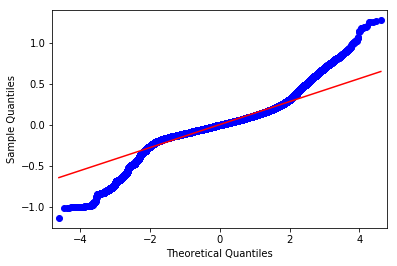

In [344]:
res = model.resid # residuals
fig = sm.qqplot(res,line='s')
plt.show()

## Lasso & Ridge

In [325]:
from sklearn.linear_model import LassoCV
lasso1 = LassoCV()
lasso1.fit(X_train, Y_train)
preds1 = lasso1.predict(X_test)
lasso1.coef_

/Users/anthonyschams/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/anthonyschams/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([ 0.00000000e+00,  1.36047096e+00,  0.00000000e+00, -2.72812479e-04,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        9.26812554e-01, -3.12213308e-01,  6.33182978e-03, -2.58032517e-03,
       -1.43914022e-02, -1.82334012e-02,  3.08561031e-03,  3.09766253e-04,
       -3.22356025e-04,  6.38153126e-03, -4.88178864e-03,  2.53183635e-02,
       -1.28104166e-03,  4.25357008e-03, -2.08986321e-02, -1.77284606e-03,
       -2.69710361e-02,  3.87469358e-16,  3.35709228e-02, -1.01844751e-03,
       -9.81688708e-03,  1.51226222e-02,  3.35928123e-02,  3.96563752e-03,
        7.40713424e-01,  1.14499694e+00,  2.43836121e-01,  5.11012383e-01,
        8.62596405e-01, -3.59562783e-01,  9.48601695e-02, -8.30888201e-01,
        0.00000000e+00, -1.09161736e-01, -1.00006193e-03,  4.60239271e-01,
       -1.50345702e-04, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [326]:
lasso1.score(X_test, Y_test)

0.9387327933443443

In [327]:
lasso1_res = Y_test - preds1

In [328]:
from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(Y_test, preds1)

In [329]:
mse1

0.019869916184567783

In [330]:
Y_test.mean()

2.6494213637908937

In [331]:
mse1/(Y_test.mean())

0.007499719167409877

(array([1.0000e+00, 0.0000e+00, 3.0000e+00, 9.0000e+00, 5.0000e+00,
        6.0000e+00, 4.8000e+01, 6.1000e+01, 3.8000e+01, 1.2000e+02,
        1.1400e+02, 1.1500e+02, 1.3100e+02, 3.7100e+02, 2.9300e+02,
        4.7200e+02, 5.8500e+02, 7.3100e+02, 1.9940e+03, 4.9290e+03,
        1.1737e+04, 1.8330e+04, 2.3968e+04, 2.3714e+04, 1.6036e+04,
        1.0477e+04, 5.4390e+03, 2.6780e+03, 1.5740e+03, 8.4100e+02,
        5.6800e+02, 4.5500e+02, 3.4400e+02, 2.6700e+02, 2.0800e+02,
        1.0900e+02, 1.1400e+02, 6.9000e+01, 3.6000e+01, 2.4000e+01,
        1.3000e+01, 7.0000e+00, 5.0000e+00, 3.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-1.15943852, -1.10917532, -1.05891212, -1.00864892, -0.95838571,
        -0.90812251, -0.85785931, -0.8075961 , -0.7573329 , -0.7070697 ,
        -0.6568065 , -0.60654329, -0.55628009, -0.50601689, -0.45575368,
        -0.40549048, -0.35522728, -0.30496408, -0.25470087, -0.20443767,
        -0.15417447, -0.10

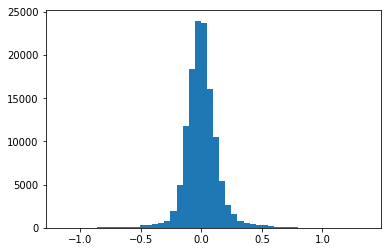

In [332]:
plt.hist(lasso1_res, bins=50)

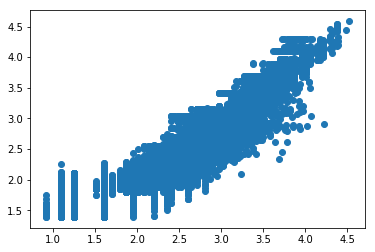

In [333]:
plt.scatter(Y_test, preds1)

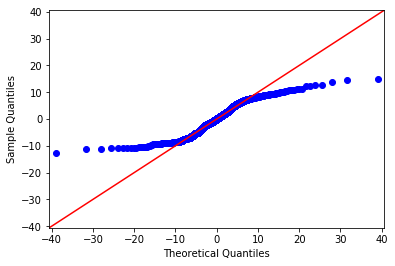

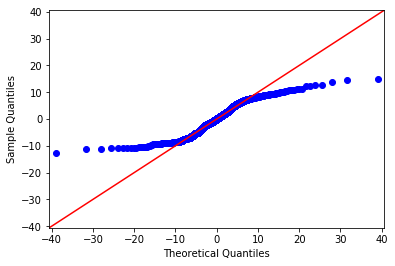

In [334]:
import scipy.stats as stats
sm.qqplot(lasso1_res, stats.t, fit=True, line=str(45))

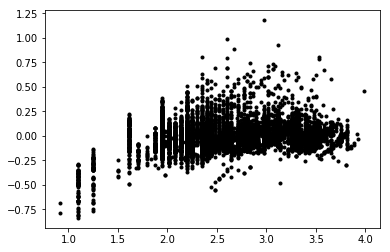

In [287]:
plt.plot(Y_train[:10000], res[:10000], 'k.')

In [288]:
X_train.loc[res[res > 0.2].index, :]

,const,ndistance,ntemp,nclouds,npressure,nrain,nhumidity,nwind,cab_type_Uber,destination_Back Bay,...,day_Thu,day_Tue,day_Wed,AMPM_PM,month_Dec,week_47,week_48,week_49,sports,wkndPM
635562,1.0,0.034582,0.141038,0.052153,-0.073358,-0.020523,-0.420912,0.240048,0,0,...,1,0,0,1,0,1,0,0,1,0
225533,1.0,0.160858,0.210610,-0.607847,-0.171715,-0.020523,-0.328320,0.085126,0,0,...,0,0,0,1,1,0,1,0,0,0
89158,1.0,0.168511,0.044363,0.272153,0.385571,-0.020523,0.042051,-0.108386,1,0,...,0,0,0,1,1,0,0,1,1,1
659752,1.0,0.071572,-0.000063,-0.247847,0.281880,-0.020523,-0.032023,0.014097,0,0,...,0,0,0,0,1,0,0,0,0,0
575290,1.0,0.010347,0.136567,0.322153,-0.104508,0.665974,0.282791,0.245081,1,0,...,0,0,0,1,0,1,0,0,0,0
722720,1.0,0.274378,0.062245,0.332153,0.133384,0.082762,0.319829,0.094634,0,0,...,0,0,0,0,1,0,1,0,0,0
1065019,1.0,0.141725,-0.160722,0.022153,0.188003,-0.020523,0.060569,-0.167670,1,0,...,0,0,0,0,1,1,0,0,0,0
445931,1.0,-0.089142,0.148302,-0.467847,0.421415,-0.020523,-0.254246,-0.197872,1,1,...,0,0,0,1,1,0,0,1,1,1
1178445,1.0,0.282031,0.076495,0.332153,0.060416,-0.005924,0.042051,0.204254,1,0,...,0,0,0,1,1,0,0,0,1,1
896369,1.0,-0.128683,0.377976,0.072153,-0.219294,-0.020523,0.208717,-0.014427,0,0,...,0,0,0,0,1,0,1,0,0,0


In [289]:
from sklearn.linear_model import RidgeCV
ridge1 = RidgeCV()
ridge1.fit(X_train, Y_train)
preds1r = ridge1.predict(X_test)
ridge1.coef_

array([ 0.00000000e+00,  1.37200655e+00,  8.00726602e-04, -1.23455732e-03,
       -2.28370823e-03,  4.39055204e-04, -2.48700644e-03,  8.72728156e-05,
       -3.42652283e-01,  6.41886912e-03, -5.99114591e-03, -1.74884046e-02,
       -2.06077002e-02,  4.06973950e-03,  7.96607628e-04, -2.17017724e-03,
        5.42341522e-03, -6.11221166e-03,  2.56796970e-02, -2.85571847e-03,
        5.44020451e-03, -2.29347646e-02, -3.51294372e-03, -2.76931067e-02,
        3.66774418e-03,  3.65051449e-02, -6.14816830e-04, -1.14701194e-02,
        1.70469384e-02,  3.50387834e-02,  6.31500959e-03,  7.43557900e-01,
        1.14785405e+00,  2.14180392e-01,  4.81383276e-01,  8.32993505e-01,
       -3.91014388e-01,  6.52340524e-02, -8.60124554e-01,  0.00000000e+00,
       -1.07912644e-01,  2.44752826e-04,  4.63194662e-01, -3.18148316e-03,
       -1.48383680e-03, -2.09728836e-03, -2.94622479e-03, -2.56215094e-03,
       -3.63449328e-03, -7.11912695e-04,  9.10183758e-04,  2.07003718e-03,
       -2.61949243e-04,  

In [290]:
ridge1.score(X_test, Y_test)

0.9367577327695863

In [291]:
ridge1_res = Y_test - preds1r

In [292]:
from sklearn.metrics import mean_squared_error
mse1r = mean_squared_error(Y_test, preds1r)

In [293]:
mse1r

0.019883455084537295

In [294]:
mse1r/Y_test.mean()

0.007538618672042469

(array([1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+01, 4.0000e+00,
        4.0000e+00, 4.7000e+01, 6.5000e+01, 3.9000e+01, 1.1600e+02,
        1.1600e+02, 1.1800e+02, 1.1400e+02, 3.8400e+02, 2.9400e+02,
        4.7400e+02, 5.7700e+02, 7.8900e+02, 1.9920e+03, 4.8480e+03,
        1.1736e+04, 1.8680e+04, 2.3826e+04, 2.3728e+04, 1.6037e+04,
        1.0352e+04, 5.4390e+03, 2.6520e+03, 1.5390e+03, 8.3600e+02,
        5.7500e+02, 4.4300e+02, 3.5000e+02, 2.6300e+02, 2.1000e+02,
        1.1700e+02, 1.1000e+02, 6.4000e+01, 4.0000e+01, 2.4000e+01,
        1.2000e+01, 7.0000e+00, 5.0000e+00, 3.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-1.16080769, -1.11046743, -1.06012716, -1.0097869 , -0.95944664,
        -0.90910638, -0.85876612, -0.80842585, -0.75808559, -0.70774533,
        -0.65740507, -0.6070648 , -0.55672454, -0.50638428, -0.45604402,
        -0.40570375, -0.35536349, -0.30502323, -0.25468297, -0.2043427 ,
        -0.15400244, -0.10

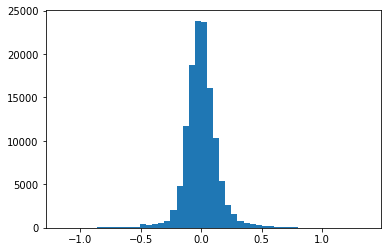

In [295]:
plt.hist(ridge1_res, bins=50)

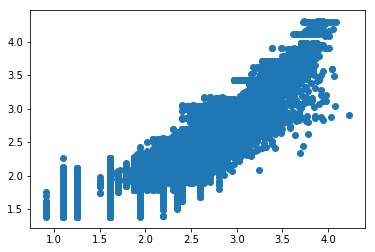

In [296]:
plt.scatter(Y_test, preds1r)

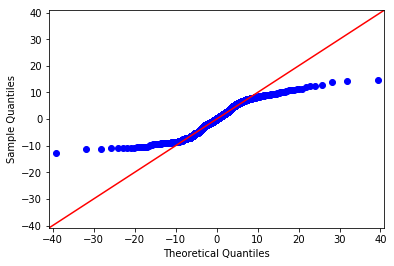

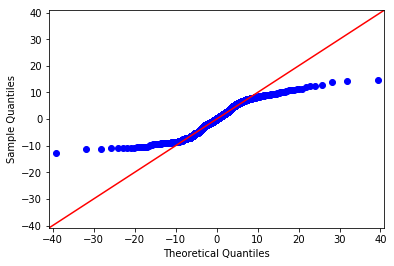

In [297]:
sm.qqplot(ridge1_res, stats.t, fit=True, line=str(45))

### Spec 2: normalized numerical and all raw one hot encoded dummies minus one and rain dummy

In [298]:
merged_df.columns

Index(['distance', 'price', 'surge_multiplier', 'time', 'merge_date', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'rushhr',
       'cab_type_Lyft', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Beacon Hill', 'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 'source_Beacon Hill',
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black 

In [335]:
X = merged_df[['ldistance', 'ndistance', 'ntemp', 'nclouds', 'npressure',
       'nhumidity', 'nwind', 'surge_multiplier', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
       'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
       'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
       'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
       'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
       'week_49', 'sports', 'wkndPM', 'rain_d']]
X = sm.add_constant(X)
Y = merged_df['nprice']

In [336]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = .2, random_state=42)

In [305]:
model = sm.OLS(Y_train, X_train).fit()

In [306]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 nprice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.247e+05
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:11:46   Log-Likelihood:             1.1296e+06
No. Observations:              508193   AIC:                        -2.259e+06
Df Residuals:                  508139   BIC:                        -2.258e+06
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.1680      0.000   -381.771      0.000      -0.169      -0.167
ndistance                               0.2384      0.000    719.950      0.000       0.238       0.239
ntemp                                  -0.0003      0.000     -0.791      0.429      -0.001       0.000
nclouds                                -0.0002      0.000     -1.474      0.140      -0.001    7.84e-05
npressure                              -0.0005      0.000     -1.130      0.259      -0.001       0.000
nhumidity                              -0.0005      0.000     -1.784      0.074      -0.001    5.18e-05
nwind                                6.043e-05      0.000      0.186      0.853      -0.001       0.001
surge_multiplier                        0.1937      0.000    490.710      0.000       0.193       0.194
cab_type_Uber                          -0.0874      0.000   -678.421      0.000      -0.088      -0.087
destination_Back Bay                    0.0032      0.000     17.989      0.000       0.003       0.004
destination_Boston University          -0.0147      0.000    -94.442      0.000      -0.015      -0.014
destination_Fenway                     -0.0180      0.000   -116.678      0.000      -0.018      -0.018
destination_Financial District          0.0075      0.000     41.410      0.000       0.007       0.008
destination_Haymarket Square           -0.0122      0.000    -77.629      0.000      -0.013      -0.012
destination_North End                  -0.0139      0.000    -90.289      0.000      -0.014      -0.014
destination_North Station               0.0054      0.000     30.092      0.000       0.005       0.006
destination_Northeastern University    -0.0145      0.000    -94.976      0.000      -0.015      -0.014
destination_South Station              -0.0149      0.000    -96.168      0.000      -0.015      -0.015
destination_Theatre District            0.0058      0.000     31.886      0.000       0.005       0.006
destination_West End                    0.0027      0.000     15.244      0.000       0.002       0.003
source_Back Bay                         0.0032      0.000     17.938      0.000       0.003       0.004
source_Boston University               -0.0170      0.000   -108.226      0.000      -0.017      -0.017
source_Fenway                          -0.0149      0.000    -96.400      0.000      -0.015      -0.015
source_Financial District               0.0070      0.000     38.566      0.000       0.007       0.007
source_Haymarket Square                -0.0101      0.000    -64.406      0.000      -0.010      -0.010
source_North End                       -0.0083      0.000    -54.501      0.000      -0.009      -0.008
source_North Station                    0.0041      0.000     22.46

In [307]:
from sklearn.linear_model import LassoCV
lasso = LassoCV()
lasso.fit(X_train, Y_train)
preds = lasso.predict(X_test)
lasso.coef_

/Users/anthonyschams/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [ ]:
lasso.score(X_test, Y_test)

In [ ]:
lasso_res = Y_test - preds

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, preds)

In [ ]:
mse

In [ ]:
Y_test.mean()

In [ ]:
mse/Y_test.mean()

In [ ]:
plt.hist(Y_test - preds, bins=50)

In [ ]:
plt.scatter(Y_test, preds)

In [ ]:
import scipy.stats as stats
sm.qqplot(lasso_res, stats.t, fit=True, line=str(45))

In [ ]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV()
ridge.fit(X_train, Y_train)
preds = ridge.predict(X_test)
ridge.coef_

In [ ]:
ridge.score(X_test, Y_test)

In [ ]:
ridge_res = Y_test - preds

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, preds)

In [ ]:
mse

In [ ]:
Y_test.mean()

In [ ]:
plt.hist(Y_test - preds, bins=50)

In [ ]:
plt.scatter(Y_test, preds)

In [ ]:
sm.qqplot(ridge_res, stats.t, fit=True, line=str(45))

### Spec 3: normalized numerical and rain and selected dummies

In [ ]:
merged_df.columns

In [ ]:
X = merged_df[['ndistance', 'ntemp', 'nclouds', 'npressure',
       'nhumidity', 'nwind', 'surge_multiplier', 'cab_type_Uber', 'destination_Back Bay',
       'source_Beacon Hill',
       'destination_Haymarket Square', 'destination_Northeastern University',
       'source_Back Bay', 'day_Fri',
       'AMPM_PM', 'month_Dec', 'sports', 'wkndPM', 'rain_d', 'Black']]
X = sm.add_constant(X)
Y = merged_df['nprice']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = .2, random_state=42)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
Y_train.shape

In [ ]:
Y_test.shape

In [ ]:
model = sm.OLS(Y_train, X_train).fit()

In [ ]:
model.summary()

In [ ]:
from sklearn.linear_model import LassoCV
lasso = LassoCV()
lasso.fit(X_train, Y_train)
preds = lasso.predict(X_test)
lasso.coef_

In [ ]:
lasso.score(X_test, Y_test)

In [ ]:
lasso_res = Y_test - preds

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, preds)

In [ ]:
mse

In [ ]:
Y_test.mean()

In [ ]:
mse/Y_test.mean()

In [ ]:
plt.hist(Y_test - preds, bins=50)

In [ ]:
plt.scatter(Y_test, preds)

In [ ]:
import scipy.stats as stats
sm.qqplot(lasso_res, stats.t, fit=True, line=str(45))

In [ ]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV()
ridge.fit(X_train, Y_train)
preds = ridge.predict(X_test)
ridge.coef_

In [ ]:
ridge.score(X_test, Y_test)

In [ ]:
ridge_res = Y_test - preds

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, preds)

In [ ]:
mse

In [ ]:
Y_test.mean()

In [ ]:
mse/Y_test.mean()

In [ ]:
plt.hist(Y_test - preds, bins=50)

In [ ]:
plt.scatter(Y_test, preds)

In [ ]:
sm.qqplot(ridge_res, stats.t, fit=True, line=str(45))

### Spec 4: normalized numerical and rain and selected dummies and capped price at 40

In [ ]:
merged_df40 = merged_df[(merged_df.price < 40)]

In [ ]:
merged_df40.head()

In [ ]:
X = merged_df40[['ndistance', 'ntemp', 'nclouds', 'npressure',
       'nhumidity', 'nwind', 'surge_multiplier', 'cab_type_Uber', 'destination_Back Bay',
       'source_Beacon Hill',
       'destination_Haymarket Square', 'destination_Northeastern University',
       'source_Back Bay', 'day_Fri',
       'AMPM_PM', 'month_Dec', 'sports', 'wkndPM', 'rain_d', 'Black']]
X = sm.add_constant(X)
Y = merged_df40['nprice']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = .2, random_state=42)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
Y_train.shape

In [ ]:
Y_test.shape

In [ ]:
model = sm.OLS(Y_train, X_train).fit()

In [ ]:
model.summary()

In [ ]:
from sklearn.linear_model import LassoCV
lasso = LassoCV()
lasso.fit(X_train, Y_train)
preds = lasso.predict(X_test)
lasso.coef_

In [ ]:
lasso.score(X_test, Y_test)

In [ ]:
lasso_res = Y_test - preds

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, preds)

In [ ]:
mse

In [ ]:
Y_test.mean()

In [ ]:
mse/Y_test.mean()

In [ ]:
plt.hist(Y_test - preds, bins=50)

In [ ]:
plt.scatter(Y_test, preds)

In [ ]:
import scipy.stats as stats
sm.qqplot(lasso_res, stats.t, fit=True, line=str(45))

In [ ]:
plt.plot(Y_train, res, 'k.')

In [ ]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV()
ridge.fit(X_train, Y_train)
preds = ridge.predict(X_test)
ridge.coef_

In [ ]:
ridge.score(X_test, Y_test)

In [ ]:
ridge_res = Y_test - preds

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, preds)

In [ ]:
mse

In [ ]:
Y_test.mean()

In [ ]:
mse/Y_test.mean()

In [ ]:
plt.hist(Y_test - preds, bins=50)

In [ ]:
plt.scatter(Y_test, preds)

In [ ]:
sm.qqplot(ridge_res, stats.t, fit=True, line=str(45))

## Notes

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
embeded_lr_selector = SelectFromModel(LassoCV(), max_features=20)
embeded_lr_selector.fit(X_train, Y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

In [ ]:
embeded_lr_feature

In [ ]:
dataSet_df = merged_df[['distance', 'surge_multiplier', 'temp', 'clouds', 'pressure', 
                        'rain', 'humidity', 'wind', 'name_Black', 'name_Black SUV', 
                        'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 
                        'name_Lyft XL', 'name_Shared', 'name_Taxi', 'name_UberPool', 'name_UberX', 
                        'name_UberXL', 'name_WAV', 'destination_Back Bay', 'destination_Beacon Hill', 
                        'destination_Boston University', 'destination_Fenway', 'destination_Financial District',
                        'destination_Haymarket Square', 'destination_North End', 'destination_North Station', 
                        'destination_Northeastern University', 'destination_South Station', 
                        'destination_Theatre District', 'destination_West End', 'source_Back Bay', 
                        'source_Beacon Hill', 'source_Boston University', 'source_Fenway',
                        'source_Financial District', 'source_Haymarket Square',
                        'source_North End', 'source_North Station',
                        'source_Northeastern University', 'source_South Station',
                         'source_Theatre District', 'source_West End','price']]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
XX= dataSet_df[['distance', 'surge_multiplier', 'temp', 'clouds', 'pressure', 
                        'rain', 'humidity', 'wind', 'name_Black', 'name_Black SUV', 
                        'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 
                        'name_Lyft XL', 'name_Shared', 'name_Taxi', 'name_UberPool', 'name_UberX', 
                        'name_UberXL', 'name_WAV', 'destination_Back Bay', 'destination_Beacon Hill', 
                        'destination_Boston University', 'destination_Fenway', 'destination_Financial District',
                        'destination_Haymarket Square', 'destination_North End', 'destination_North Station', 
                        'destination_Northeastern University', 'destination_South Station', 
                        'destination_Theatre District', 'destination_West End', 'source_Back Bay', 
                        'source_Beacon Hill', 'source_Boston University', 'source_Fenway',
                        'source_Financial District', 'source_Haymarket Square',
                        'source_North End', 'source_North Station',
                        'source_Northeastern University', 'source_South Station',
                         'source_Theatre District', 'source_West End']]
YY = dataSet_df['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XX.values, YY.values, test_size=0.33, random_state=42)

In [ ]:
y_train.shape

In [ ]:
regr = RandomForestRegressor(max_depth=4, random_state=137, n_estimators=1000)
regr.fit(X_train, y_train)

In [ ]:
y_rf = regr.predict(X_test)

In [ ]:
fimpDict = {}
for fimp in list(zip(XX.columns, regr.feature_importances_)):
    print(fimp)
    fimpDict.update({fimp[0]:fimp[1]})

In [ ]:
kk = list(fimpDict.keys())
vv = list(fimpDict.values())


fimpDF = pd.DataFrame({'features':kk,
                      'importance':vv})









In [ ]:
fimpDF.sort_values(by='importance')

In [ ]:
plt.hist(y_test-y_rf, bins=50)

In [ ]:
regr2 = RandomForestRegressor(max_depth=5, random_state=137, n_estimators=2000)
regr2.fit(X_train, y_train)

In [ ]:
fimpDict2 = {}
for fimp in list(zip(XX.columns, regr2.feature_importances_)):
    print(fimp)
    fimpDict2.update({fimp[0]:fimp[1]})

In [ ]:
kk = list(fimpDict.keys())
vv = list(fimpDict.values())


fimpDF = pd.DataFrame({'features':kk,
                      'importance':vv})

In [ ]:
fimpDF.sort_values(by='importance')

## haven't run yet

In [ ]:
merged_df = pd.read_csv('data/merged_df.csv')

In [ ]:
merged_df = merged_df[(merged_df.price < 40) & (merged_df.price >5)]

In [ ]:
X = merged_df.drop(['price', 'location', 'merge_date',
                    'lprice', 'distance', 'cab_type_Lyft', 'destination_Back Bay',
                    'source_Back Bay', 'name_Taxi'], axis=1)
X = sm.add_constant(X)
X.reset_index(drop=True,inplace=True)
Y = pd.DataFrame(norm_Y.T)
Y.reset_index(drop=True,inplace=True)


In [ ]:
y_array = np.array(merged_df['price'])
norm_y = preprocessing.normalize([y_array])
merged_df['nnprice'] = pd.DataFrame(norm_y.T)

In [ ]:
d_array = np.array(merged_df['distance'])
norm_d = preprocessing.normalize([d_array])
merged_df['ndistance'] = pd.DataFrame(norm_d.T)

In [ ]:
t_array = np.array(merged_df['temp'])
norm_t = preprocessing.normalize([t_array])
merged_df['ntemp'] = pd.DataFrame(norm_t.T)

In [ ]:
c_array = np.array(merged_df['clouds'])
norm_c = preprocessing.normalize([c_array])
merged_df['nclouds'] = pd.DataFrame(norm_c.T)

In [ ]:
p_array = np.array(merged_df['pressure'])
norm_p = preprocessing.normalize([p_array])
merged_df['npressure'] = pd.DataFrame(norm_p.T)

In [ ]:
r_array = np.array(merged_df['rain'])
norm_r = preprocessing.normalize([r_array])
merged_df['nrain'] = pd.DataFrame(norm_r.T)

In [ ]:
h_array = np.array(merged_df['humidity'])
norm_h = preprocessing.normalize([h_array])
merged_df['nhumidity'] = pd.DataFrame(norm_h.T)

In [ ]:
w_array = np.array(merged_df['wind'])
norm_w = preprocessing.normalize([w_array])
merged_df['nwind'] = pd.DataFrame(norm_w.T)

## Time Series Analysis

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [443]:
avg_by_timestamp = df.groupby(by='date_time').mean()

count_by_timestamp = df.groupby(by='date_time').count()['id']
avg2 = avg_by_timestamp.drop(avg_by_timestamp[avg_by_timestamp.iloc[:, 2] < 15].index)['price']
count_by_timestamp.index = pd.to_datetime(count_by_timestamp.index)
avg2.index = pd.to_datetime(avg2.index)
avg3 = avg2.groupby(pd.Grouper(freq='h')).ffill()
count2 = count_by_timestamp.groupby(pd.Grouper(freq='h')).ffill()

In [475]:
def get_avg_by_cab(df, cab_type, gb_feature, feature):
    avg_by_timestamp = df[df.cab_type == cab_type].groupby(by=gb_feature).mean()
    avg = avg_by_timestamp[feature]
    avg.index = pd.to_datetime(avg.index)
    avg_price = avg.groupby(pd.Grouper(freq='h')).ffill()
    return avg_price

In [484]:
Uber_avg_price = get_avg_by_cab(df, 'Uber', 'date_time', 'price')
Lyft_avg_price = get_avg_by_cab(df, 'Lyft', 'date_time', 'price')

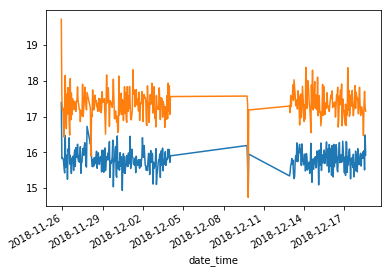

In [485]:
plt.figure()
Uber_avg_price.plot()
Lyft_avg_price.plot()

In [486]:
Uber_first_segment = Uber_avg_price['2018-11-26':'2018-12-04']
Lyft_first_segment = Lyft_avg_price['2018-11-26':'2018-12-04']

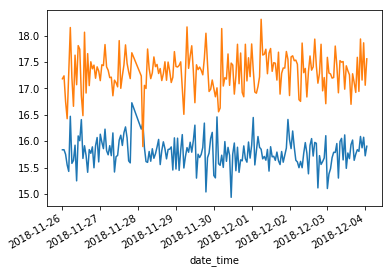

In [487]:
Uber_first_segment.plot()
Lyft_first_segment.plot()

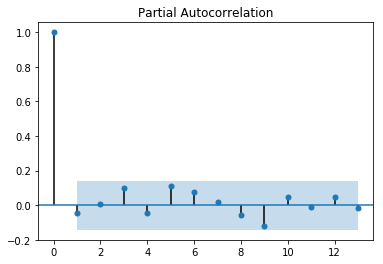

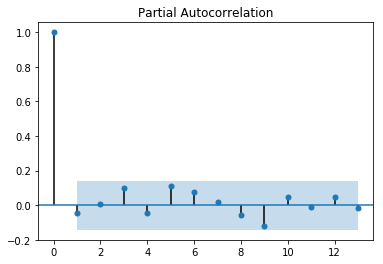

In [488]:
plot_pacf(Uber_first_segment, lags=np.floor(np.sqrt(len(Uber_first_segment))))

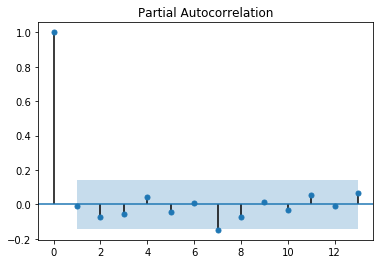

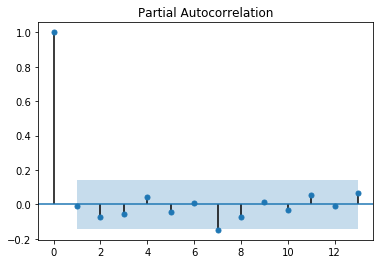

In [489]:
plot_pacf(Lyft_first_segment, lags=np.floor(np.sqrt(len(Lyft_first_segment))))

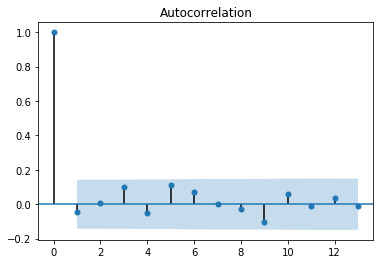

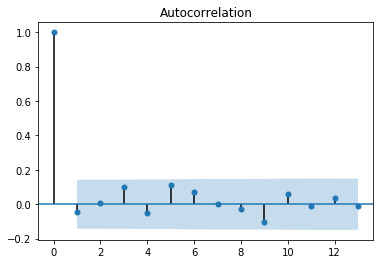

In [490]:
plot_acf(Uber_first_segment, lags=np.floor(np.sqrt(len(Uber_first_segment))))

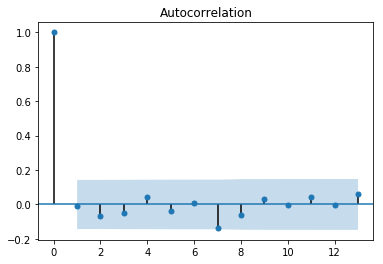

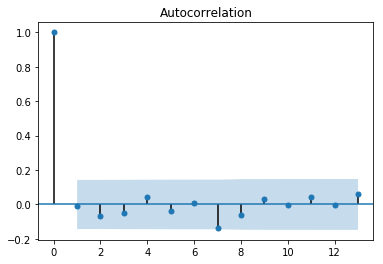

In [491]:
plot_acf(Lyft_first_segment, lags=np.floor(np.sqrt(len(Lyft_first_segment))))